# Week 7: Cleaning (Text) Data 

In this notebook we use the `nltk` python library to perform basic natural language processing tasks. NLTK stands for `natural language toolkit`, and can be used for a lot of standard tasks related to cleaning and analysing text data.

We will be using the dataset that we worked with last week, the combined comment sections of two Reddit posts. Although you are encouraged to use the files that you made last week, I have also provided the pre-made files to ensure everyone is able to start in the same place.

This week, we will count word frequencies, which will lead to observations about `stop words`, and `lemmatisation`. We will use the word frequencies to compare the two different comment sections, and use a pre-trained sentiment analysis tool to estimate the sentiments of the comments. The homework will contain an optional exercise using word frequencies and a `Naive Bayes` classifier to guess which comment section a particular comment came from.

In [1]:
%%capture
# Run this cell to install the nltk library using the Python package manager pip
!pip install nltk

In [2]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk

from collections import Counter

### Load your data files

<div class="alert alert-info">

**Exercise 0.1:** Read the CSV files from last week into two dataframes.
</div>

In [3]:
# pandas does all the work for us

mammoths_df = pd.read_csv('mammoths.csv')
remote_df = pd.read_csv('remote_work.csv')

In [4]:
# checking that we got the same thing as before
mammoths_df.head()

,body,created_at,id,parent,score,post,has_emoji,clean_body,sentiment
0,when you say it like that - gimme 2,2023-02-01 07:42:00,j6r1s1s,t1_j6qxv18,6,10py29t,False,"['when', 'you', 'say', 'it', 'like', 'that', '...",0.3612
1,Mammork?\n\nI would that make them hammoths?,2023-02-01 10:18:59,j6rd2o8,t1_j6qxv18,3,10py29t,False,"['mammork', 'i', 'would', 'that', 'make', 'the...",0.0000
2,Mmmmmmmm mammoth pork,2023-02-01 06:52:37,j6qxv18,t1_j6obhxv,22,10py29t,False,"['mmmmmmmm', 'mammoth', 'pork']",0.0000
3,It’ll just be made from pressed pork.,2023-01-31 19:16:08,j6obhxv,t1_j6notr0,68,10py29t,False,"['itll', 'just', 'be', 'made', 'from', 'presse...",0.0000
4,11 years before they’re extinct again,2023-02-01 06:51:58,j6qxt2e,t1_j6notr0,7,10py29t,False,"['11', 'years', 'before', 'theyre', 'extinct',...",0.0000


## Cleaning Data

Text data is often very messy to work with. There can be a lot of annoying $pecial characters, spelling misteaks, Capitalisation choices, and artefacts of the source material like newlines `\n`. We will take a simple approach to cleaning - remove anything that isn't alphanumeric and make everything lowercase. You may be more careful about this approach if the research question calls for it. For example, keeping track of sentence and paragraph breaks is often helpful.

In [5]:
# to split up a string between the spaces:
example_string = 'The quick brown fox jumped over the lazy dog            '
example_string.split()

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

In [6]:
# to make a string lowercase
example_string.lower()

'the quick brown fox jumped over the lazy dog            '

In [7]:
# to remove extra whitespace around a string
example_string.strip()

'The quick brown fox jumped over the lazy dog'

In [8]:
# all together
example_string.lower().strip().split()

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

In [9]:
# here we use another nice property of pandas!
# if you write a function, you can apply it to every entry in a column at once!

# our basic cleaning function
def clean_text(text):
    return [re.sub('[^a-z0-9]', '', w.lower()) for w in text.strip().split()]

# now we apply it all at once using pandas
mammoths_df['clean_body'] = mammoths_df['body'].apply(clean_text)
remote_df['clean_body'] = remote_df['body'].apply(clean_text)

In [10]:
# Let's look at one example:
# We've removed the two \n characters and the punctuation, and split the words into a list
# The vocab is made up which will make things more difficult later

mammoths_df.iloc[1,:]

body             Mammork?\n\nI would that make them hammoths?
created_at                                2023-02-01 10:18:59
id                                                    j6rd2o8
parent                                             t1_j6qxv18
score                                                       3
post                                                  10py29t
has_emoji                                               False
clean_body    [mammork, i, would, that, make, them, hammoths]
sentiment                                                 0.0
Name: 1, dtype: object

In [11]:
# For a more standard text this seems more reasonable
remote_df.iloc[1,:]

body          I was able to leverage my experience and the l...
created_at                                  2023-01-31 23:12:07
id                                                      j6pd2pm
parent                                               t1_j6p4jgg
score                                                         2
post                                                    10plq1f
has_emoji                                                 False
clean_body    [i, was, able, to, leverage, my, experience, a...
sentiment                                                0.8756
Name: 1, dtype: object

## Word Frequencies

Computational linguists have found a number of surprising regularities in language which can be used in computational social science. For example, the frequency with which words are used tends to be exponentially distributed, so that the most frequent words are **far** more common than the next most frequent words.This also holds true within subject areas, where some vocabulary words are extremely common within their area of use, but they are often very uncommon in general language. This can be used to identify the topic of a body of text based on the frequent words within it.

As an example, if you overheard the words `formal hall`, `college`, and `tutorial` you might guess that person is talking about Oxford. The words are rare in general usage, but in a specific context they are very standard.

<div class="alert alert-info">

**Exercise 0.2:** Count the most common words in each dataframe using a Counter

</div>

In [12]:
# A Counter goes through the items in a list or dictionary and tells you how many there are of each
txt_example = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

Counter(txt_example)

Counter({'the': 2,
         'quick': 1,
         'brown': 1,
         'fox': 1,
         'jumped': 1,
         'over': 1,
         'lazy': 1,
         'dog': 1})

In [13]:
# We need two for loops to get the words one at a time rather than the comments one at a time

counts = Counter(word for text in mammoths_df['clean_body'] for word in text)

    

In [14]:
# Counters have a most_common() method which tells us which words we saw the most

# Let's put it in a dataframe and look at the top and bottom few

mammoth_counts_df = pd.DataFrame(counts.most_common(), columns = ['word','count'])

print(mammoth_counts_df.head())

print(mammoth_counts_df.tail())

  word  count
0  the    800
1   to    566
2    a    503
3  and    382
4   of    350
         word  count
3489   seemed      1
3490     star      1
3491     wars      1
3492  execute      1
3493       66      1


<div class="alert alert-info">

**Exercise 0.2b:** We'll learn how to make plots next week. For now, I'll show you a plot of the frequencies of the words in this comment section

</div>

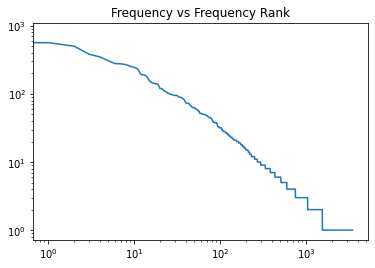

In [15]:
# Note that this plot is logarithmic on both axes
# This tells us that (as expected) a small number of words make up the vast majority of the text

plt.loglog(mammoth_counts_df.index, mammoth_counts_df['count'])
plt.title('Frequency vs Frequency Rank')
plt.show()

In [16]:
# In fact, just these 87 words make up half the total words used even though there are 3494 total unique words

mammoth_counts_df[mammoth_counts_df['count'].cumsum() < (mammoth_counts_df['count'].sum()/2)]['word'].values

array(['the', 'to', 'a', 'and', 'of', 'in', 'it', 'that', 'i', 'they',
       'is', 'this', 'mammoth', 'for', 'we', 'be', 'are', 'but', 'not',
       'with', 'have', 'its', 'years', 'you', 'just', 'like', 'on', 'if',
       'back', 'so', 'mammoths', 'about', 'an', '', 'can', 'from', 'was',
       'do', 'will', 'as', 'would', 'or', 'why', 'what', 'them', 'dna',
       'were', 'there', 'their', 'how', 'could', 'extinct', 'all', 'when',
       'time', 'elephant', 'think', 'im', 'elephants', 'one', 'woolly',
       'even', 'at', 'get', 'some', 'dont', 'more', 'species', 'jurassic',
       'going', 'see', 'park', 'up', 'now', 'been', 'by', 'people',
       'bring', 'out', 'go', 'into', 'no', 'know', 'then', 'well', 'make',
       'theyre'], dtype=object)

<div class="alert alert-info">

**Exercise 1.1:** Use the methods we have just demonstrated to count the word frequencies in the `remote_df`
</div>

In [17]:
# We need two for loops to get the words one at a time rather than the comments one at a time

counts = Counter(word for text in remote_df['clean_body'] for word in text)

    

In [18]:
# Counters have a most_common() method which tells us which words we saw the most

# Let's put it in a dataframe and look at the top and bottom few

remote_counts_df = pd.DataFrame(counts.most_common(), columns = ['word','count'])

print(remote_counts_df.head())

print(remote_counts_df.tail())

  word  count
0  the   1132
1   to   1108
2    i   1052
3  and    847
4    a    747
            word  count
3966   dedicated      1
3967         800      1
3968  midmorning      1
3969    browsing      1
3970   debugging      1


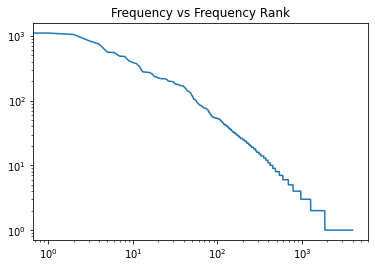

In [19]:
# Just like for the mammoths, this relationship is logarithmic

plt.loglog(remote_counts_df.index, remote_counts_df['count'])
plt.title('Frequency vs Frequency Rank')
plt.show()

In [20]:
# This time just these 64 words make up half the total words used even though there are 3971 total unique words

remote_counts_df[remote_counts_df['count'].cumsum() < (remote_counts_df['count'].sum()/2)]['word'].values

array(['the', 'to', 'i', 'and', 'a', 'work', 'of', 'in', 'my', 'that',
       'is', 'for', 'it', 'you', 'at', 'time', 'more', 'not', 'have',
       'home', 'from', 'office', 'this', 'on', 'working', 'are', 'but',
       'get', 'with', 'hours', 'so', 'people', 'me', 'be', 'im', 'its',
       'or', 'if', 'dont', 'day', 'do', 'they', 'like', 'can', 'all',
       'up', 'was', 'just', 'as', 'an', '', 'commute', 'back', 'out',
       'when', 'we', 'because', 'no', 'your', 'wfh', 'about', 'some',
       'now'], dtype=object)

<div class="alert alert-info">
<b>Exercise 1.2:</b> Compare the two lists of top words. How easy are they to tell apart?
</div>

In [21]:
# remote work
remote_counts_df[remote_counts_df['count'].cumsum() < (remote_counts_df['count'].sum()/2)]['word'].values

array(['the', 'to', 'i', 'and', 'a', 'work', 'of', 'in', 'my', 'that',
       'is', 'for', 'it', 'you', 'at', 'time', 'more', 'not', 'have',
       'home', 'from', 'office', 'this', 'on', 'working', 'are', 'but',
       'get', 'with', 'hours', 'so', 'people', 'me', 'be', 'im', 'its',
       'or', 'if', 'dont', 'day', 'do', 'they', 'like', 'can', 'all',
       'up', 'was', 'just', 'as', 'an', '', 'commute', 'back', 'out',
       'when', 'we', 'because', 'no', 'your', 'wfh', 'about', 'some',
       'now'], dtype=object)

In [22]:
# mammoths 

mammoth_counts_df[mammoth_counts_df['count'].cumsum() < (mammoth_counts_df['count'].sum()/2)]['word'].values

array(['the', 'to', 'a', 'and', 'of', 'in', 'it', 'that', 'i', 'they',
       'is', 'this', 'mammoth', 'for', 'we', 'be', 'are', 'but', 'not',
       'with', 'have', 'its', 'years', 'you', 'just', 'like', 'on', 'if',
       'back', 'so', 'mammoths', 'about', 'an', '', 'can', 'from', 'was',
       'do', 'will', 'as', 'would', 'or', 'why', 'what', 'them', 'dna',
       'were', 'there', 'their', 'how', 'could', 'extinct', 'all', 'when',
       'time', 'elephant', 'think', 'im', 'elephants', 'one', 'woolly',
       'even', 'at', 'get', 'some', 'dont', 'more', 'species', 'jurassic',
       'going', 'see', 'park', 'up', 'now', 'been', 'by', 'people',
       'bring', 'out', 'go', 'into', 'no', 'know', 'then', 'well', 'make',
       'theyre'], dtype=object)

A lot of these words are very similar in both lists. Of those, nearly all of them are words you would find **everywhere** in the English language. Words that are too frequent are not very useful for analysing the text, because you would find them in any text.

## Stop Words

We have counted up all the words in each comment section and found that the top words are very similar in each case even though the topics are very different. To help deal with words that are too common, it is typical to remove a standard list of common words, called `stop words`. Most NLP packages will have their own concept of stop words to remove. You may also want to customise the stop words based on your context. We will start with the standard stop words from NLTK.

In [23]:
# here we download the stopwords used in NLTK

nltk.download('stopwords')
from nltk.corpus import stopwords

print(stopwords.words('english'))

stopwords = stopwords.words('english')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class="alert alert-info">
<b>Exercise 2.1:</b> Recreate the Counters for each post, but this time don't include stop words
</div>

In [24]:
# This time the list of words is more unique to the subject area
# It also takes more words to capture 50% of the total usage

counts = Counter(word for text in mammoths_df['clean_body'] for word in text if word not in stopwords)
mammoth_counts_df = pd.DataFrame(counts.most_common(), columns = ['word','count'])

mammoth_counts_df[mammoth_counts_df['count'].cumsum() < (mammoth_counts_df['count'].sum()/2)]['word'].values
 

array(['mammoth', 'years', 'like', 'back', 'mammoths', '', 'would', 'dna',
       'could', 'extinct', 'time', 'elephant', 'think', 'im', 'elephants',
       'one', 'woolly', 'even', 'get', 'dont', 'species', 'jurassic',
       'going', 'see', 'park', 'people', 'bring', 'go', 'know', 'well',
       'make', 'theyre', 'thats', 'cant', 'already', 'still', 'humans',
       'animals', 'way', 'wooly', 'animal', 'extinction', 'warming',
       'scientists', 'actually', 'didnt', 'really', 'enough', 'also',
       'need', 'thing', 'colossal', 'great', 'probably', 'global', 'much',
       'new', 'read', 'long', 'change', 'climate', 'good', 'human', 'ice',
       'remember', 'meat', 'ago', 'life', 'something', 'saying', 'doesnt',
       'ive', 'right', 'point', 'stop', 'getting', 'sure', 'wrong',
       'idea', 'man', 'many', '5', 'take', 'world', 'us', 'help',
       'science', 'want', 'around', '4', 'believe', 'cloning', 'arctic',
       'next', 'company', 'say', 'big', 'things', 'yeah', 'last',

In [25]:
# This time the list of words is more unique to the subject area
# It also takes more words to capture 50% of the total usage

counts = Counter(word for text in remote_df['clean_body'] for word in text if word not in stopwords)
remote_counts_df = pd.DataFrame(counts.most_common(), columns = ['word','count'])

remote_counts_df[remote_counts_df['count'].cumsum() < (remote_counts_df['count'].sum()/2)]['word'].values
    

array(['work', 'time', 'home', 'office', 'working', 'get', 'hours',
       'people', 'im', 'dont', 'day', 'like', '', 'commute', 'back',
       'wfh', 'much', 'also', 'remote', 'go', 'even', 'would', 'less',
       'job', 'hour', 'commuting', 'done', 'want', 'getting', 'business',
       'way', 'life', '2', 'every', 'take', 'need', 'one', 'lunch',
       'better', 'ive', 'week', 'thats', 'article', 'going', 'still',
       'spend', 'make', 'extra', 'days', 'really', 'us', 'actually',
       'money', 'traffic', 'company', 'never', 'minutes', 'insider',
       'lot', 'think', 'know', 'see', 'id', 'around', 'shit', 'big',
       'able', 'since', 'saved', 'well', 'things', 'instead', 'drive',
       'meetings', 'could', 'youre', '5', 'fuck', 'long', 'good', 'lol',
       'everyone', 'workers', 'yeah', 'doesnt', 'isnt', 'bullshit',
       'something', 'maybe', 'got', 'away', 'theres', 'many', 'boss',
       'remotely', 'bad', 'driving', 'jobs', 'gas', 'years', 'theyre',
       'cant', 'sure

You might still notice a problem here. What about words like `mammoth` and `mammoths`? Should we really be counting them separately? What about `work` and `working`?

## Stemming and Lemmatisation

The process of combining words of the same root into a single `token` is called either `stemming` or `lemmatisation`. Stemming is the more basic approach. You chop off the end of the word to get a shared set of letters which should be in common across different forms. This seems intellectually suspicious, but works pretty well, with our examples both being resolved: `mammoths` becomes `mammoth` and `working` becomes `work`. Lemmatisation is somewhat more complicated, and uses a dictionary to find root words. For mammoths, the result is the same, but for a word like `working`, you might lemmatise into `working` to avoid the ambiguity of the multiple meanings of `work`.


<div class="alert-info alert">

**Example 3.1:** Use the NLTK lemmatizer on a few example words:

</div>

In [26]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [27]:
# print out the result of lemmatizing each word in this phase:
# this doesn't seem perfect

example_words = 'mammoths do not like working remotely because they prefer social activities'.split()

[lemmatizer.lemmatize(word) for word in example_words]

['mammoth',
 'do',
 'not',
 'like',
 'working',
 'remotely',
 'because',
 'they',
 'prefer',
 'social',
 'activity']


<div class="alert-info alert">

**Example 3.2:** Use the NLTK stemmer on a few example words:

</div>

In [28]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [29]:
# using the same list as before, but stemming

example_words = 'mammoths do not like working remotely because they prefer social activities'

[stemmer.stem(word) for word in example_words.split()]

['mammoth',
 'do',
 'not',
 'like',
 'work',
 'remot',
 'becaus',
 'they',
 'prefer',
 'social',
 'activ']

<div class="alert-info alert">

**Example 3.3:** Use the NLTK lemmatizer on the reddit posts and then retry the word counting (exclude stop words)

</div>

In [30]:
# This time the list of words is more unique to the subject area
# It also takes more words to capture 50% of the total usage

lemmatizer = WordNetLemmatizer()

counts = Counter(lemmatizer.lemmatize(word) for text in mammoths_df['clean_body'] for word in text if word not in stopwords)
mammoth_counts_df = pd.DataFrame(counts.most_common(), columns = ['word','count'])

mammoth_counts_df[mammoth_counts_df['count'].cumsum() < (mammoth_counts_df['count'].sum()/2)]['word'].values
 

array(['mammoth', 'year', 'elephant', 'like', 'back', '', 'would', 'time',
       'dna', 'animal', 'could', 'extinct', 'think', 'im', 'human', 'one',
       'get', 'woolly', 'even', 'dont', 'specie', 'jurassic', 'going',
       'see', 'park', 'go', 'people', 'thing', 'bring', 'make', 'know',
       'well', 'theyre', 'thats', 'cant', 'scientist', 'already', 'still',
       'way', 'need', 'extinction', 'wooly', 'warming', 'change',
       'actually', 'didnt', 'really', 'great', 'enough', 'say', 'also',
       'colossal', 'climate', 'mean', 'probably', 'global', 'much', 'new',
       'read', 'long', 'right', 'good', 'ice', 'remember', 'life', 'want',
       'take', 'meat', 'point', 'stop', 'ago', 'something', 'saying',
       'doesnt', 'ive', 'getting', 'sure', 'world', 'wrong', 'hope',
       'idea', 'help', 'science', 'man', 'many', '5', 'clone', 'u',
       'around', '4', 'last', 'believe', 'cloning', 'gene', 'find',
       'arctic', 'next', 'movie', 'ecosystem', 'company', 'big', 'yea

In [31]:
# This time the list of words is more unique to the subject area
# It also takes more words to capture 50% of the total usage

lemmatizer = WordNetLemmatizer()

counts = Counter(lemmatizer.lemmatize(word) for text in remote_df['clean_body'] for word in text if word not in stopwords)
remote_counts_df = pd.DataFrame(counts.most_common(), columns = ['word','count'])

remote_counts_df[remote_counts_df['count'].cumsum() < (remote_counts_df['count'].sum()/2)]['word'].values
 

array(['work', 'time', 'hour', 'home', 'office', 'working', 'day', 'get',
       'people', 'im', 'dont', 'like', 'commute', '', 'back', 'job',
       'wfh', 'go', 'much', 'also', 'remote', 'even', 'would', 'le',
       'commuting', 'article', 'business', 'week', 'make', 'company',
       'want', 'done', 'life', 'take', 'way', 'need', 'getting', 'one',
       'thing', 'lunch', '2', 'every', 'better', 'ive', 'minute', 'thats',
       'going', 'still', 'spend', 'meeting', 'extra', 'year', 'save', 'u',
       'really', 'actually', 'money', 'lot', 'traffic', 'think', 'never',
       'know', 'insider', 'worker', 'see', 'id', 'around', 'shit', 'big',
       'able', 'since', 'fuck', 'mean', 'saved', 'well', 'instead',
       'drive', 'could', 'saving', 'youre', '5', 'long', 'good', 'lol',
       'everyone', 'yeah', 'doesnt', 'isnt', 'bullshit', 'say',
       'something', 'maybe', 'got', 'car', 'walk', 'away', 'there',
       'many', 'bos', 'put', 'remotely', 'break', 'come', 'bad', 'feel',
   

## Normalised Counts

Unsurprisingly, the length of a piece of text changes how many different words can appear in it. This is a complex point, because the change is both the direct mathematical one, but also a change in the context and thus in the words the author might choose. Short texts, like on social media, use words differently than long essays. Since our texts share a similar context, we will normalise by the size of the corpus to produce comparable word frequencies between the two.

You could perform this step either at the level of the corpus, or on each piece of text. We will start with the two posts as our level of aggregation.

<div class="alert-info alert">

**Exercise 4.1:** Use the lemmatized word counts to create normalised frequencies for each post

</div>

In [32]:
mammoth_counts_df['frequency'] = mammoth_counts_df['count']/mammoth_counts_df['count'].sum()
remote_counts_df['frequency'] = remote_counts_df['count']/remote_counts_df['count'].sum()


In [33]:
# now we can compare how frequently we see the word `work`
# it is 20x more frequent in the remote work article!

print(f"Frequency of `work` in mammoths: {mammoth_counts_df[mammoth_counts_df['word'] == 'work']['frequency'].values[0]}")
print(f"Frequency of `work` in remote work: {remote_counts_df[remote_counts_df['word'] == 'work']['frequency'].values[0]}")


Frequency of `work` in mammoths: 0.0015916526660182157
Frequency of `work` in remote work: 0.03202410176299933


<div class="alert-info alert">

**Exercise 4.2:** Make a function which returns the frequency of a word in each comment section, or zero if it does not appear.

</div>

In [34]:
# I'm setting the index of the dfs to the words to make it easier to use them for lookups

mammoth_counts_df = mammoth_counts_df.set_index('word')
remote_counts_df = remote_counts_df.set_index('word')



In [35]:
def freq_lookup(word):
    if word in mammoth_counts_df.index:
        mf = mammoth_counts_df.loc[word,'frequency']
    else: 
        mf = 0
    if word in remote_counts_df.index:
        rf = remote_counts_df.loc[word, 'frequency']
    else:
        rf = 0
    return round(mf,5), round(rf,5)

In [36]:
freq_lookup('mammoth')

(0.02538, 0)

In [38]:
# Now, if we find an example post, we can guess which article it came from:

# most of these words have similar frequencies in both, but `commuting` is far more frequent in remote work
# therefore, we think this is a remote work post (of course we know it is)

post = remote_df['clean_body'][100]

for word in post:
    print(word + '|' +str(freq_lookup(word)))

and|(0, 0)
nothing|(0.00133, 0.00106)
beats|(0, 0)
working|(0.00088, 0.01216)
in|(0, 6e-05)
your|(0, 0)
pjs|(0, 0.00033)


## Sentiment

Finally, we will do a very basic pass at sentiment analysis. As usual, you need to be careful that the tool you use is suited for the context. NLTK has a simple pre-trained sentiment analyzer which gives scores for short pieces of text like reddit comments. We will use it to demonstrate the idea. If you want to perform sentiment analysis in your summative or thesis, I would recommend looking into `Hugging Face` for a better suited pre-trained model.

Because the relationship between words matters more here, we do not want to remove stopwords or stem/lemmatize.

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


<div class="alert-info alert">

**Exercise 5.1:** Use the sentiment analyzer on the example sentence

</div>

In [ ]:

example_words = 'mammoths do not like working remotely because they prefer social activities'

sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example_words)

We see here that 82.6% of the sentence was neutral words, but 17.4% of the words were negative in mood. The model does a custom combination to conclude that this is a moderately negative sentence. (Seems right to me)

<div class="alert-info alert">

**Exercise 5.2:** Use the sentiment analyzer on the raw body text in the databases to add a new `sentiment` column

</div>

In [ ]:
mammoths_df['sentiment'] = mammoths_df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])
remote_df['sentiment'] = remote_df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])

<div class="alert-info alert">

**Exercise 5.3:** Find a positive and negative comment from each post and see how well the analyzer worked 

</div>

In [ ]:
# This is the most negative mammoths post - it does seem very negative
mammoths_df[mammoths_df['sentiment'] == mammoths_df['sentiment'].min()]['body'].values[0]

In [ ]:
# This is the most positive mammoths post - it has a large quote from the news article which may be misleading
mammoths_df[mammoths_df['sentiment'] == mammoths_df['sentiment'].max()]['body'].values[0]

In [ ]:
# This is the most negative remote work post
remote_df[remote_df['sentiment'] == remote_df['sentiment'].min()]['body'].values[0]

In [ ]:
# This is the most positive remote work post
remote_df[remote_df['sentiment'] == remote_df['sentiment'].max()]['body'].values[0]

In [ ]:
# Taking a look at the distribution, the mammoth comments have plenty of positive and negative
mammoths_df[mammoths_df['sentiment']!=0]['sentiment'].hist(density=True)
plt.plot()

In [ ]:
# the remote work comments have a more positive skew 

remote_df[remote_df['sentiment']!=0]['sentiment'].hist(density=True)
plt.plot()

## Save your work

We'll use this data again next week for visualizations. Save each of the following dfs to a file:

- mammoth_counts_df
- remote_counts_df
- mammoths_df
- remote_df

In [ ]:
mammoth_counts_df.to_csv('mammoths_counts.csv')
remote_counts_df.to_csv('remote_counts.csv')
mammoths_df.to_csv('mammoths.csv',index=False)
remote_df.to_csv('remote_work.csv',index=False)

## Homework: Naive Bayes Classifier (Optional)

A Naive Bayes classifier is a basic NLP technique which lets you classify a text based on previously established categories. It assumes that each word in a text is drawn at random from a bag of possible words, where the bag is different depending on the category. (Like what we did above, where `commuting` is more common in the remote work category.) 

Using these probabilities, the total probability of the text belonging to each category is just the combined probabilities of each word appearing if the text was from that category, so we multiply the probabilities together.

In [ ]:
def freq_ratio(word):
    smoothing_prb = 1/(1/mammoth_counts_df['frequency'].min() + 1/remote_counts_df['frequency'].min())
    if word in mammoth_counts_df.index:
        mf = mammoth_counts_df.loc[word,'frequency']
    else: 
        mf = smoothing_prb
    if word in remote_counts_df.index:
        rf = remote_counts_df.loc[word, 'frequency']
    else:
        rf = smoothing_prb
    return mf/rf

In [ ]:
def naive_bayes(text):
    freqs = 1
    for word in text:
        freqs = freqs * freq_ratio(word) 
    return freqs/(1+freqs)
    

In [ ]:
pred = naive_bayes(mammoths_df['clean_body'].iloc[0])
print(f'Prob of mammoths: {pred}') 

In [ ]:
pred1 = mammoths_df['clean_body'].apply(naive_bayes)
pred2 = remote_df['clean_body'].apply(naive_bayes)

Overall, our classifier is pretty good! It was only wrong on 78 out of the ~1800 comments. However, there are a lot of things you would need to be more careful about in a real classification task. Most notably, we are testing the final accuracy on the training data!

In [ ]:
print(f"Correctly predicted mammoth: {len(pred1[pred1>.5])}")
print(f"Incorrectly predicted remote work: {len(pred1[pred1<=.5])}")
print(f"Incorrectly predicted mammoth: {len(pred2[pred2>.5])}")
print(f"Corrently predicted remote work: {len(pred2[pred2<=.5])}")